In [2]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


In [3]:
def get_I(l,c,h):
    t = 0.05
    y_ave = (h**2-c**2+c*np.sqrt(b**2+c**2))/(2*h-2*c+2*np.sqrt(b**2+c**2))
    I = 2*(h/2+c/2-y_ave)**2*(h-c)*t+(y_ave-c*y_ave+1/3*c**2)*t*np.sqrt(b**2+c**2)
    return I

In [4]:
def compute(l_cons,c_cons,h_cons,N_xi,draw,restrictN):
    b_cons = np.sqrt((0.5*l_cons - h_cons + c_cons)**2-c_cons**2)
    N_eta = N_xi
    # Inputs:
    # =======
    #    N_xi     : Number of nodes in the xi direction.
    #    N_eta    : Number of nodes in the eta direction
    #    cc       : height of the base, c
    #    hh       : height of the channel, h 
    #
    # Outputs:
    # ========
    #    Solution : A xi-eta matrix containing the solution
    #    Flowrate : The flowrate throught eh channel
    #    I_xx     : The moment of inertia of the channel
    #
    # Some additional information for the function:
    #
    # In this pseudo code, the following conventions are used:
    #
    #    1) The computational domain xi-eta has values of (0,0) corresponding to the
    #       bottom left corner of the physical and computational domain. Correspondingly,
    #       the upper-right corner in the xi-eta domain has a (xi, eta) value of (1,1).
    #
    #    2) We use a node map in the matrix 'Node'. Node(i,j) grabs node reference
    #       number. Using the Node matrix, we can easily stamp/stencil the related
    #       values into the finite difference matrix. To determine how the Node matrix
    #       looks, you can easily type the creation commands in the command prompt.

    assert N_xi == N_eta

    d_xi  = 1/(N_xi-1)
    d_eta = 1/(N_eta-1)

    delta = d_xi

    TotalNodes = N_xi*N_eta

    # Create uniform grid in computational space
    xi0, eta0 = np.meshgrid(np.linspace(0,1,N_xi), np.linspace(0,1,N_eta), indexing='ij')

    # Create map (i,j) -> I (index in global matrix)
    Node = np.arange(0,TotalNodes).reshape((N_xi,N_eta), order='F')

    xi = np.zeros(TotalNodes)
    eta = np.zeros(TotalNodes)
    for i in range(N_eta):
        for j in range(N_xi):
            xi[Node[i,j]] = xi0[i,j]
            eta[Node[i,j]] = eta0[i,j]

    # Allocate space for right hand side vector and global matrix.
    # Make sure to use a sparse matrix format (here we use list of lists (lil)
    A = lil_matrix((TotalNodes, TotalNodes))
    RHS = -np.ones(TotalNodes)

    Ones = np.ones(TotalNodes)

    # Construct partial difference
    # zero-th order
    x = b_cons * xi
    y = (c_cons*Ones + (h_cons-c_cons)*eta)*xi + h_cons * eta * (Ones - xi)
    # 1st order
    x_xi = b_cons * Ones
    x_eta = 0*Ones
    y_xi = c_cons*(Ones - eta)
    y_eta = h_cons*Ones - c_cons*xi
    # 2nd order
    x_xixi = 0*Ones
    x_xieta = 0*Ones
    x_etaeta = 0*Ones

    y_xixi = 0*Ones
    y_xieta = -c_cons * Ones
    y_etaeta = 0*Ones

    # Construct the Jacobian, and a,b,c,d,e

    J = x_xi * y_eta - x_eta * y_xi

    a = x_eta**2 + y_eta**2
    b = x_xi *x_eta + y_xi * y_eta
    c = x_xi**2 + y_xi**2

    alpha = 0
    beta = -2*b*y_xieta

    d = x_eta*beta/J
    e = -x_xi*beta/J

    # Construct A

    # First loop over interior nodes
    for i in range(1,N_xi-1):
        for j in range(1,N_eta-1):
            CN = Node[i,j]   # Current node

            # Calculate mapping coefficients
            J2 = J[CN]**2
            d2 = delta**2
            A[CN, Node[i  ,j  ]] = 1/J2 /d2 * (-2*a[CN]-2*c[CN])
            
            A[CN, Node[i+1,j  ]] = 1/J2 * (a[CN]/d2 + d[CN]/2/delta)
            A[CN, Node[i-1,j  ]] = 1/J2 * (a[CN]/d2 - d[CN]/2/delta)
            A[CN, Node[i,j+1  ]] = 1/J2 * (c[CN]/d2 + e[CN]/2/delta)
            A[CN, Node[i,j-1  ]] = 1/J2 * (c[CN]/d2 - e[CN]/2/delta) 
            
            A[CN, Node[i+1,j+1]] = -b[CN]/J2 /d2 /2
            A[CN, Node[i+1,j-1]] = b[CN]/J2 /d2 /2
            A[CN, Node[i-1,j+1]] = b[CN]/J2 /d2 /2
            A[CN, Node[i-1,j-1]] = -b[CN]/J2 /d2 /2



    # Now boudnary conditions
    for i in range(N_xi):     # Bottom boundary
        CN = Node[i,0] 
        A[CN, CN] = 1
        RHS[CN] = 0
        
    for j in range(1,N_eta):  # Right boundary
        CN = Node[N_eta - 1,j]
        A[CN, CN] = 1
        RHS[CN] = 0

    for j in range(1,N_eta-1):  # Left boundary
        CN = Node[0,j]
        A[CN,CN] = -3/2*y_eta[CN]/delta 
        A[CN,Node[1,j]] = 2*y_eta[CN]/delta
        A[CN,Node[2,j]] = -y_eta[CN]/delta/2
        A[CN,Node[0,j+1]] = -y_xi[CN]/delta/2
        A[CN,Node[0,j-1]] = +y_xi[CN]/delta/2
        RHS[CN] = 0


    for i in range(1,N_xi-1):     # Top boundary
        CN = Node[i,N_eta-1]
        A[CN,CN] = 3/2*x_xi[CN]/delta 
        A[CN,Node[i,N_eta-1-1]] = -2*x_xi[CN]/delta
        A[CN,Node[i,N_eta-1-2]] = +x_xi[CN]/delta/2
        A[CN,Node[i+1,N_eta-1]] = -x_eta[CN]/delta/2
        A[CN,Node[i-1,N_eta-1]] = +x_eta[CN]/delta/2
        RHS[CN] = 0

    for i in [0]:     # Top boundary
        CN = Node[i,N_eta-1]
        A[CN,CN] = 3/2*x_xi[CN]/delta + 3/2*x_eta[CN]/delta 
        A[CN,Node[i,N_eta-1-1]] = -2*x_xi[CN]/delta
        A[CN,Node[i,N_eta-1-2]] = +x_xi[CN]/delta/2
        A[CN,Node[i+1,N_eta-1]] = -2*x_eta[CN]/delta
        A[CN,Node[i+2,N_eta-1]] = +x_eta[CN]/delta/2
        RHS[CN] = 0

    # Compute solution and resahpe
    u = spsolve(A.tocsr(),RHS)
    x0 = x.reshape((N_xi,N_eta), order='F')
    y0 = y.reshape((N_xi,N_eta), order='F')
    u0 = u.reshape((N_xi,N_eta), order='F')
    
    # extract a restricted version
    
    restri_u = np.zeros(restrictN*restrictN)
    for i in range(restrictN):
        for j in range(restrictN):
            restri_u[i*restrictN+j] = u[(i*N_xi+j)*int((N_xi-1)/(restrictN-1))]
    #print('u=',u)
    #print('restr_u=',restri_u)
    if draw:
        # Define the (x, y) points at which you want to evaluate u(x, y)
        #   Plot grid
        plt.figure(1)
        plt.plot(x0, y0, 'k')
        plt.plot(np.transpose(x0), np.transpose(y0))
        plt.axis('equal')
        plt.show()


        #   Plot color contours
        plt.figure(2)
        plt.pcolor(x0,y0,u0)
        plt.colorbar()
        plt.axis('equal')
        plt.show()

        #   Plot line contours
        plt.figure(3)
        xc = [x0[0,0], x0[N_xi-1,0], x0[N_xi-1,N_eta-1], x0[0,N_eta-1], x0[0,0]]
        yc = [y0[0,0], y0[N_xi-1,0], y0[N_xi-1,N_eta-1], y0[0,N_eta-1], y0[0,0]]
        plt.fill(xc,yc, 'k')
        CS = plt.contour(x0,y0,u0)
        plt.clabel(CS, inline=True, fontsize=10)
        plt.axis('equal')
        plt.show()

    

    # Compute Flowrate and I_xx
    FlowRate = 0
    I_xx = 0

    for i in range(0,N_xi):
        for j in range(0,N_eta-1):
            if i!=N_xi-1 and j != N_xi - 1:
                CN1 = Node[i,j]   # Current node
                CN2 = Node[i+1,j]   # Current node
                CN3 = Node[i,j+1]   # Current node
                CN4 = Node[i+1,j+1]   # Current node
                u_loc = 0.25*(u[CN1]*J[CN1] + u[CN2]*J[CN2] + u[CN3]*J[CN3] + u[CN4]*J[CN4])
                FlowRate += u_loc*delta**2
    FlowRate *= 2
    #print('flow rate:', FlowRate)
    #print('I_xx:',I_xx)
    return FlowRate, restri_u

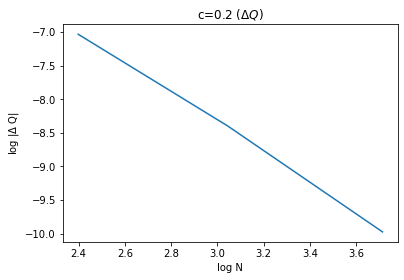

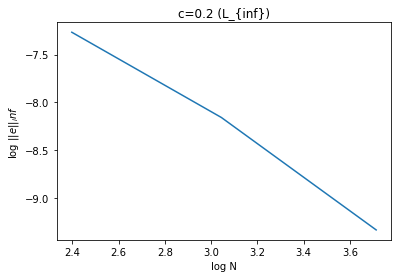

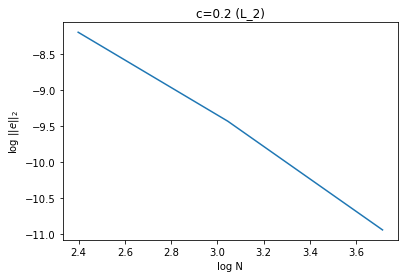

In [13]:
#Compare Q
# define some constant
l_cons = 3.0
c_cons = 0.2
h_cons = 1.0
#N_xi =  81
draw = 0


diff_Q = []
diff_L_inf = []
diff_L_2 = []
N_l = [np.log(11),np.log(21),np.log(41)]

for N_xi in [11,21,41]:
    baseQ, base_restri_u = compute(l_cons,c_cons,h_cons,81,draw,N_xi)
    Q, restri_u = compute(l_cons,c_cons,h_cons,N_xi,draw,N_xi)
    #print('diff_Q',Q-baseQ)
    diff_Q.append(np.log(abs(Q-baseQ)))
    diff_lat = restri_u - base_restri_u
    diff_lat = [abs(i) for i in diff_lat]
    #print('diff_lat',diff_lat)
    #print(len(diff_lat))
    #print('difQ',diff_lat)
    diff_L_inf.append(np.log(max(diff_lat)))
    diff_L_2.append(np.log(np.sqrt(sum([i**2 for i in diff_lat])*(1/N_xi**2))))
    

plt.plot(N_l,diff_Q)
plt.title("c=0.2 ($\Delta Q$)")
plt.xlabel("log N")
plt.ylabel("log |$\Delta$ Q|")
plt.show()
plt.plot(N_l,diff_L_inf)
plt.title("c=0.2 (L_{inf})")
plt.xlabel("log N")
plt.ylabel("log $\|\|e\|\|_inf$")
plt.show()
plt.plot(N_l,diff_L_2)
plt.title("c=0.2 (L_2)")
plt.xlabel("log N")
plt.ylabel("log $\|\|e\|\|_2$")
plt.show()


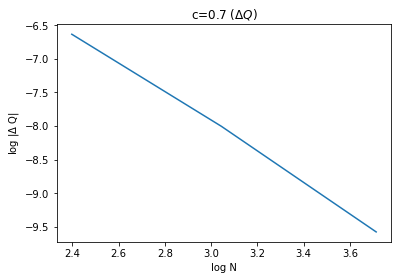

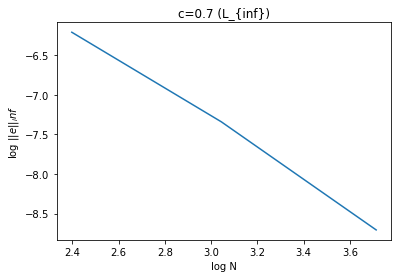

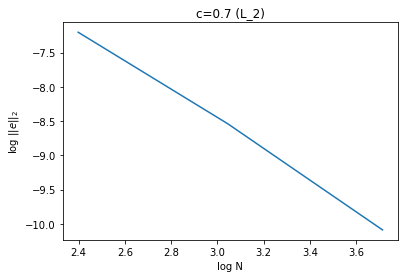

In [14]:
#Compare Q
# define some constant
l_cons = 3.0
c_cons = 0.7
h_cons = 1.0
#N_xi =  81
draw = 0


diff_Q = []
diff_L_inf = []
diff_L_2 = []
N_l = [np.log(11),np.log(21),np.log(41)]

for N_xi in [11,21,41]:
    baseQ, base_restri_u = compute(l_cons,c_cons,h_cons,81,draw,N_xi)
    Q, restri_u = compute(l_cons,c_cons,h_cons,N_xi,draw,N_xi)
    #print('diff_Q',Q-baseQ)
    diff_Q.append(np.log(abs(Q-baseQ)))
    diff_lat = restri_u - base_restri_u
    diff_lat = [abs(i) for i in diff_lat]
    #print('diff_lat',diff_lat)
    #print(len(diff_lat))
    #print('difQ',diff_lat)
    diff_L_inf.append(np.log(max(diff_lat)))
    diff_L_2.append(np.log(np.sqrt(sum([i**2 for i in diff_lat])*(1/N_xi**2))))
    

plt.plot(N_l,diff_Q)
plt.title("c=0.7 ($\Delta Q$)")
plt.xlabel("log N")
plt.ylabel("log |$\Delta$ Q|")
plt.show()
plt.plot(N_l,diff_L_inf)
plt.title("c=0.7 (L_{inf})")
plt.xlabel("log N")
plt.ylabel("log $\|\|e\|\|_inf$")
plt.show()
plt.plot(N_l,diff_L_2)
plt.title("c=0.7 (L_2)")
plt.xlabel("log N")
plt.ylabel("log $\|\|e\|\|_2$")
plt.show()
